In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats

from scipy.special import polygamma

import warnings
warnings.filterwarnings('ignore')

In [2]:
def Gamma_shape(model, y, max_iter = 10, max_eps = 1e-4):
    prior_weights = np.ones(len(y))
    fitted_value = model.fittedvalues
    Dbar = model.deviance / model.df_resid
    alpha = (6+2*Dbar)/(Dbar*(6+Dbar))
    
    fixed = -y/fitted_value - np.log(fitted_value) + np.log(prior_weights) + 1 + np.log(y + (y==0)*1)
    eps = 1
    itr = 0
    
    
    while ((np.abs(eps) > max_eps) & (itr < max_iter)):
        sc = np.sum(prior_weights * (fixed + np.log(alpha) - polygamma(0, prior_weights * alpha)))
        inf = np.sum(prior_weights * (prior_weights * polygamma(1, prior_weights*alpha) - 1 / alpha))
        eps = sc / inf
        alpha += eps
        
        itr += 1
    return (alpha, np.sqrt(1/inf))
# Credit: https://github.com/cran/MASS/blob/master/R/gamma.shape.R

In [3]:
data = pd.read_csv('../../data/Avocado/avocado.csv', index_col = 0)
data.shape

(18249, 13)

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
alpha, loc, beta = stats.gamma.fit(data['AveragePrice'])

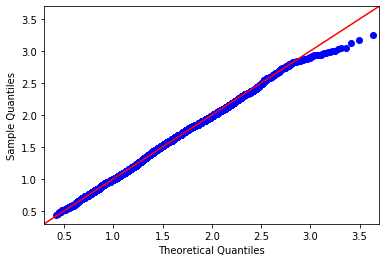

In [6]:
sm.ProbPlot(data['AveragePrice'], stats.gamma, distargs = (alpha, ), loc = loc, scale = beta).qqplot(line="45")
plt.show()
# Roughly fit gamma distribution

In [7]:
train, test = train_test_split(data, test_size = 0.2, random_state = 0)
train.shape, test.shape

((14599, 13), (3650, 13))

In [8]:
train, validate = train_test_split(train, test_size = 0.3, random_state = 0)
train.shape, validate.shape

((10219, 13), (4380, 13))

In [9]:
X = train[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
# Cannot be too large

X = X.rename(columns = {'Small Bags': 'Small_Bags',
                        'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
regions = df.columns.tolist()
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

Small_Volume_type = ['4046_organic']
Intermediate_Volume_type = ['4225_organic']
Large_Volume_type = ['4770_organic']

Small_Bags_type = ['Small_Bags_organic']
Large_Bags_type = ['Large_Bags_organic']
XLarge_Bags_type = ['XLarge_Bags_organic']

X['4046_organic'] = X['4046'] * X['organic']
X['4225_organic'] = X['4225'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

Small_Volume_season = []
Intermediate_Volume_season = []
Large_Volume_season = []

Small_Volume_type_season = []
Intermediate_Volume_type_season = []
Large_Volume_type_season = []

Small_Bags_season = []
Large_Bags_season = []
XLarge_Bags_season = []

Small_Bags_type_season = []
Large_Bags_type_season = []
XLarge_Bags_type_season = []

type_season = []

for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]
    Small_Volume_season.append(col_name)
    col_name = '4225' + '_' + season
    X[col_name] = X['4225'] * X[season]
    Intermediate_Volume_season.append(col_name)
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]
    Large_Volume_season.append(col_name)

    col_name = 'Small_Bags' + '_' + season
    X[col_name] = X['Small_Bags'] * X[season]
    Small_Bags_season.append(col_name)    
    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    Large_Bags_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]
    XLarge_Bags_season.append(col_name)
    
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    type_season.append(col_name)
    
    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    Small_Volume_type_season.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + season
    X[col_name] = X['4225'] * X['organic'] * X[season]
    Intermediate_Volume_type_season.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season] 
    Large_Volume_type_season.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
    Small_Bags_type_season.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    Large_Bags_type_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]  
    XLarge_Bags_type_season.append(col_name)        

Small_Volume_region = []
Intermediate_Volume_region = []
Large_Volume_region = []

Small_Volume_region_season = []
Intermediate_Volume_region_season = []
Large_Volume_region_season = []

Small_Volume_type_region = []
Intermediate_Volume_type_region = []
Large_Volume_type_region = []

Small_Volume_type_region_season = []
Intermediate_Volume_type_region_season = []
Large_Volume_type_region_season = []

Small_Bags_region = []
Large_Bags_region = []
XLarge_Bags_region = []

Small_Bags_region_season = []
Large_Bags_region_season = []
XLarge_Bags_region_season = []

Small_Bags_type_region = []
Large_Bags_type_region = []
XLarge_Bags_type_region = []

Small_Bags_type_region_season = []
Large_Bags_type_region_season = []
XLarge_Bags_type_region_season = []

type_region = []
region_season = []
type_region_season = []

for region in regions:
    col_name = '4046' + '_' + region
    X[col_name] = X['4046'] * X[region]
    Small_Volume_region.append(col_name)    
    col_name = '4225' + '_' + region
    X[col_name] = X['4225'] * X[region]
    Intermediate_Volume_region.append(col_name)    
    col_name = '4770' + '_' + region
    X[col_name] = X['4770'] * X[region]
    Large_Volume_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + region
    X[col_name] = X['Small_Bags'] * X[region]
    Small_Bags_region.append(col_name)
    col_name = 'Large_Bags' + '_' + region
    X[col_name] = X['Large_Bags'] * X[region]
    Large_Bags_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + region        
    X[col_name] = X['XLarge_Bags'] * X[region]
    XLarge_Bags_region.append(col_name)
        
    col_name = 'organic' + '_' + region
    X[col_name] = X['organic'] * X[region]
    type_region.append(col_name)
        
    col_name = '4046' + '_' + 'organic' + '_' + region
    X[col_name] = X['4046'] * X['organic'] * X[region]
    Small_Volume_type_region.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + region
    X[col_name] = X['4225'] * X['organic'] * X[region]
    Intermediate_Volume_type_region.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + region
    X[col_name] = X['4770'] * X['organic'] * X[region]
    Large_Volume_type_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
    Small_Bags_type_region.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
    Large_Bags_type_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 
    XLarge_Bags_type_region.append(col_name)
    
    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = region + '_' + season
        X[col_name] = X[region] * X[season]
        region_season.append(col_name)
        
        col_name = '4046' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X[region] * X[season]
        Small_Volume_region_season.append(col_name)
        col_name = '4225' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X[region] * X[season] 
        Intermediate_Volume_region_season.append(col_name)
        col_name = '4770' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X[region] * X[season]
        Large_Volume_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X[region] * X[season]
        Small_Bags_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X[region] * X[season]
        Large_Bags_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[region] * X[season]
        XLarge_Bags_region_season.append(col_name)
        
        col_name = 'organic' + '_' + region + '_' + season
        X[col_name] = X['organic'] * X[region] * X[season]
        type_region_season.append(col_name)
        
        col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
        Small_Volume_type_region_season.append(col_name)
        col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
        Intermediate_Volume_type_region_season.append(col_name)
        col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  
        Large_Volume_type_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
        Small_Bags_type_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
        Large_Bags_type_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  
        XLarge_Bags_type_region_season.append(col_name)

In [10]:
full_model = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit()
full_model.summary()
# Using log as the link function as it is easier to interpret.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                10219
Model:                            GLM   Df Residuals:                     7468
Model Family:                   Gamma   Df Model:                         2750
Link Function:                    log   Scale:                       0.0096241
Method:                          IRLS   Log-Likelihood:                 7576.4
Date:                Thu, 25 Feb 2021   Deviance:                       71.538
Time:                        03:45:17   Pearson chi2:                     71.9
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.3504      0.146      2.402      0.016       0.065       0.636
4046                                              -0.1976      1.093     -0.181      0.856      -2.339       1.944
4225                                              -1.0592      0.644     -1.646      0.100      -2.321       0.202
4770                                              42.0411     28.121      1.495      0.135     -13.074      97.156
Small_Bags                                        -1.0442      2.007     -0.520      0.603      -4.978       2.890
Large_Bags                                         9.5866      7.138      1.343      0.179      -4.404      23.577
XLarge_Bags                                       40.1209     64.883      0.618      0.536     -87.047     167.289
organic                                            0.2667      0.157      1.701      0.089      -0.041       0.574
Albany                                             0.1088      0.171      0.634      0.526      -0.227       0.445
Atlanta                                           -0.1631      0.175     -0.930      0.353      -0.507       0.181
BaltimoreWashington                                0.1427      0.178      0.800      0.423      -0.207       0.492
Boise                                             -0.0783      0.196     -0.399      0.690      -0.462       0.306
Boston                                            -0.0720      0.190     -0.380      0.704      -0.443       0.299
BuffaloRochester                                   0.1396      0.185      0.756      0.449      -0.222       0.501
California                                        -0.0797      0.181     -0.439      0.660      -0.435       0.276
Charlotte                                          0.0433      0.165      0.262      0.793      -0.281       0.367
Chicago                                            0.3899      0.189      2.060      0.039       0.019       0.761
CincinnatiDayton                                  -0.0186      0.174     -0.107      0.915      -0.361       0.323
Columbus                                          -0.0497      0.164     -0.304      0.761      -0.370       0.271
DallasFtWorth                                     -0.0565      0.210     -0.269      0.788      -0.468       0.355
Denver                                            -0.0854      0.215     -0.396      0.692      -0.508       0.337
Detroit                                            0.0972      0.186      0.523      0.601      -0.267       0.462
GrandRapids                                       -0.0346      0.186     -0.185      0.853      -0.400       0.331
GreatLakes                                        -0.1271      0.186     -0.682      0.495   

In [11]:
full_model_dispersion = Gamma_shape(full_model, y)[0]
full_model_dispersion = 1/full_model_dispersion
full_model_dispersion

0.006992355673492666

In [12]:
full_model.deviance/(full_model_dispersion * full_model.df_resid)
# A little bit lack of fit.

1.3699664018315356

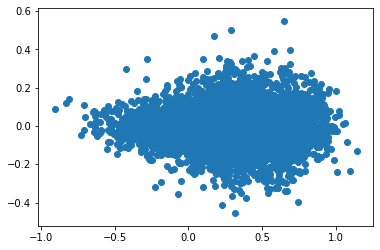

In [13]:
xb = sm.add_constant(X).values @ full_model.params.values

plt.scatter(xb, full_model.resid_deviance)
plt.show()
# No pattern

In [14]:
reduced_4_way = Small_Volume_type_region_season + Intermediate_Volume_type_region_season + Large_Volume_type_region_season + \
                Small_Bags_type_region_season + Large_Bags_type_region_season + XLarge_Bags_type_region_season

In [15]:
reduced_4_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [16]:
reduced_4_way_model_dispersion = Gamma_shape(reduced_4_way_model, y)[0]
reduced_4_way_model_dispersion = 1/reduced_4_way_model_dispersion
reduced_4_way_model_dispersion

0.00900776347762963

In [17]:
chi_stat = reduced_4_way_model.deviance/reduced_4_way_model_dispersion - full_model.deviance/full_model_dispersion
df = reduced_4_way_model.df_resid - full_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 3.432509139922331
Critical value: 28.36186255317465
p-value: 1.0


In [18]:
final_model = reduced_4_way_model
final_model_dispersion = reduced_4_way_model_dispersion

In [19]:
reduced_3_way = Small_Volume_type_region + Small_Volume_type_season + Small_Volume_region_season + \
                Intermediate_Volume_type_region + Intermediate_Volume_type_season + Intermediate_Volume_region_season +\
                Large_Volume_type_region + Large_Volume_type_season + Large_Volume_region_season +\
                Small_Bags_type_region + Small_Bags_type_season + Small_Bags_region_season +\
                Large_Bags_type_region + Large_Bags_type_season + Large_Bags_region_season +\
                XLarge_Bags_type_region + XLarge_Bags_type_season + XLarge_Bags_region_season +\
                type_region_season

In [20]:
reduced_3_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way + reduced_3_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [21]:
reduced_3_way_model_dispersion = Gamma_shape(reduced_3_way_model, y)[0]
reduced_3_way_model_dispersion = 1/reduced_3_way_model_dispersion
reduced_3_way_model_dispersion

0.017520967834227137

In [22]:
chi_stat = reduced_3_way_model.deviance/reduced_3_way_model_dispersion - final_model.deviance/final_model_dispersion
df = reduced_3_way_model.df_resid - final_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 14.498614423713661
Critical value: 38.4427902710714
p-value: 1.0


In [23]:
final_model = reduced_3_way_model
final_model_dispersion = reduced_3_way_model_dispersion

In [24]:
reduced_2_way = Small_Volume_type + Small_Volume_region + Small_Volume_season +\
                Intermediate_Volume_type + Intermediate_Volume_region + Intermediate_Volume_season +\
                Large_Volume_type + Large_Volume_region + Large_Volume_season +\
                Small_Bags_type + Small_Bags_region + Small_Bags_season +\
                Large_Bags_type + Large_Bags_region + Large_Bags_season +\
                XLarge_Bags_type + XLarge_Bags_region + XLarge_Bags_season +\
                type_season + type_region + region_season

In [25]:
reduced_2_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [26]:
reduced_2_way_model_dispersion = Gamma_shape(reduced_2_way_model, y)[0]
reduced_2_way_model_dispersion = 1/reduced_2_way_model_dispersion
reduced_2_way_model_dispersion

0.03114346362905356

In [27]:
chi_stat = reduced_2_way_model.deviance/reduced_2_way_model_dispersion - final_model.deviance/final_model_dispersion
df = reduced_2_way_model.df_resid - final_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 23.197154395487814
Critical value: 24.75909900421264
p-value: 0.709704525310219


In [28]:
final_model = reduced_2_way_model
final_model_dispersion = reduced_2_way_model_dispersion

In [29]:
def data_preprocessing(data, regions = regions):
    X = data[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
    y = data['AveragePrice']

    X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
    
    X = X.rename(columns = {'Small Bags': 'Small_Bags',
                            'Large Bags': 'Large_Bags',
                            'XLarge Bags': 'XLarge_Bags'})

    df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

    df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
    df = df[regions]
    X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

    X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                   'Summer' if (x == 6 or x == 7 or x == 8) else
                   'Autumn' if (x == 9 or x == 10 or x == 11) else
                   'Winter' for x in pd.DatetimeIndex(X['Date']).month]
    X = X.drop('Date', axis = 1)

    df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

    X['4046_organic'] = X['4046'] * X['organic']
    X['4225_organic'] = X['4225'] * X['organic']
    X['4770_organic'] = X['4770'] * X['organic']

    X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
    X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
    X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = '4046' + '_' + season
        X[col_name] = X['4046'] * X[season]
        col_name = '4225' + '_' + season
        X[col_name] = X['4225'] * X[season]        
        col_name = '4770' + '_' + season
        X[col_name] = X['4770'] * X[season]

        col_name = 'Small_Bags' + '_' + season
        X[col_name] = X['Small_Bags'] * X[season]  
        col_name = 'Large_Bags' + '_' + season
        X[col_name] = X['Large_Bags'] * X[season]
        col_name = 'XLarge_Bags' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[season]

        col_name = 'organic' + '_' + season
        X[col_name] = X['organic'] * X[season]

        col_name = '4046' + '_' + 'organic' + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[season]
        col_name = '4225' + '_' + 'organic' + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[season]
        col_name = '4770' + '_' + 'organic' + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[season] 

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]         

    for region in regions:
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]   
        col_name = '4225' + '_' + region
        X[col_name] = X['4225'] * X[region]   
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]

        col_name = 'Small_Bags' + '_' + region
        X[col_name] = X['Small_Bags'] * X[region]
        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]

        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]

        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4225' + '_' + 'organic' + '_' + region
        X[col_name] = X['4225'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 

        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]

            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4225' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X[region] * X[season] 
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]

            col_name = 'Small_Bags' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]

            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  

            col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  

    return (X, y)

In [30]:
validate_X, validate_y = data_preprocessing(validate)

In [31]:
print('Final Model:', mean_squared_error(validate_y, final_model.predict(sm.add_constant(validate_X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)))))

Final Model: 0.06751404201096586


In [32]:
print('Up to two-way interaction effect:', mean_squared_error(validate_y, reduced_3_way_model.predict(sm.add_constant(validate_X.drop(reduced_4_way + reduced_3_way, axis = 1)))))
print('Up to three-way interaction effect:', mean_squared_error(validate_y, reduced_4_way_model.predict(sm.add_constant(validate_X.drop(reduced_4_way, axis = 1)))))
print('Full model:', mean_squared_error(validate_y, full_model.predict(sm.add_constant(validate_X))))
# Extrapolation may occurs

Up to two-way interaction effect: 0.04599971675870447
Up to three-way interaction effect: 2.2159651387418573
Full model: 2.049334336317489


In [33]:
test_X, test_y = data_preprocessing(test)

In [34]:
print('Train data:', mean_squared_error(y, final_model.predict(sm.add_constant(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)))))
print('Validate data:', mean_squared_error(validate_y, final_model.predict(sm.add_constant(validate_X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)))))
print('Test data:', mean_squared_error(test_y, final_model.predict(sm.add_constant(test_X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)))))
# Consistent

Train data: 0.06384062597203982
Validate data: 0.06751404201096586
Test data: 0.06753942127467934


In [35]:
def data_preprocessing(data, regions = regions):
    X = data[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
    y = data['AveragePrice']

    X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
    
    X = X.rename(columns = {'Small Bags': 'Small_Bags',
                            'Large Bags': 'Large_Bags',
                            'XLarge Bags': 'XLarge_Bags'})

    df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

    df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
    df = df[regions]
    X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

    X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                   'Summer' if (x == 6 or x == 7 or x == 8) else
                   'Autumn' if (x == 9 or x == 10 or x == 11) else
                   'Winter' for x in pd.DatetimeIndex(X['Date']).month]
    X = X.drop('Date', axis = 1)

    df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('season', axis = 1)
    
    return (X, y)

In [36]:
X, y = data_preprocessing(data)

In [37]:
model = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                18249
Model:                            GLM   Df Residuals:                    18185
Model Family:                   Gamma   Df Model:                           63
Link Function:                    log   Scale:                        0.031203
Method:                          IRLS   Log-Likelihood:                 111.97
Date:                Thu, 25 Feb 2021   Deviance:                       576.68
Time:                        03:51:56   Pearson chi2:                     567.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1464      0.010     14.720      0.000       0.127       0.166
4046                   -0.0249      0.004     -6.328      0.000      -0.033      -0.017
4225                    0.0152      0.005      3.267      0.001       0.006       0.024
4770                   -0.1716      0.030     -5.672      0.000      -0.231      -0.112
Small_Bags              0.0157      0.008      1.903      0.057      -0.000       0.032
Large_Bags             -0.0393      0.014     -2.733      0.006      -0.068      -0.011
XLarge_Bags             1.2169      0.140      8.677      0.000       0.942       1.492
organic                 0.3561      0.003    128.760      0.000       0.351       0.362
Albany                  0.0375      0.014      2.757      0.006       0.011       0.064
Atlanta                -0.1287      0.014     -9.459      0.000      -0.155      -0.102
BaltimoreWashington     0.0182      0.014      1.337      0.181      -0.008       0.045
Boise                  -0.1256      0.014     -9.238      0.000      -0.152      -0.099
Boston                  0.0137      0.014      1.004      0.315      -0.013       0.040
BuffaloRochester        0.0177      0.014      1.300      0.194      -0.009       0.044
California             -0.0928      0.014     -6.689      0.000      -0.120      -0.066
Charlotte               0.0525      0.014      3.865      0.000       0.026       0.079
Chicago                 0.0392      0.014      2.872      0.004       0.012       0.066
CincinnatiDayton       -0.2258      0.014    -16.593      0.000      -0.252      -0.199
Columbus               -0.1862      0.014    -13.697      0.000      -0.213      -0.160
DallasFtWorth          -0.3383      0.014    -24.850      0.000      -0.365      -0.312
Denver                 -0.2067      0.014    -15.099      0.000      -0.233      -0.180
Detroit                -0.1641      0.014    -12.053      0.000      -0.191      -0.137
GrandRapids            -0.0003      0.014     -0.021      0.984      -0.027       0.026
GreatLakes             -0.1182      0.014     -8.420      0.000      -0.146      -0.091
HartfordSpringfield     0.1723      0.014     12.676      0.000       0.146       0.199
Houston                -0.3715      0.014    -27.276      0.000      -0.398      -0.345
Indianapolis           -0.1362      0.014    -10.023      0.000      -0.163      -0.110
Jacksonville           -0.0103      0.014     -0.758      0.449      -0.037       0.016
LasVegas               -0.1127      0.014     -8.289      0.000      -0.139      -0.086
LosAngeles             -0.2320      0.014    -16.828      0.000      -0.259      -0.205
Louisville             -0.1594      0.014    -11.726      0.000      -0.186      -0.133
MiamiFtLauderdale      -0.0455      0.014     -3.345      0.001      -0.072      -0.019
Mid

In [38]:
model_dispersion = Gamma_shape(model, y)[0]
model_dispersion = 1/model_dispersion
model_dispersion

0.031436064294853225

In [39]:
model.deviance/(model_dispersion * model.df_resid)
# No lack of fit

1.0087766480774707

In [40]:
model = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = model_dispersion)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                18249
Model:                            GLM   Df Residuals:                    18185
Model Family:                   Gamma   Df Model:                           63
Link Function:                    log   Scale:                        0.031436
Method:                          IRLS   Log-Likelihood:                 112.23
Date:                Thu, 25 Feb 2021   Deviance:                       576.68
Time:                        03:51:57   Pearson chi2:                     567.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1464      0.010     14.665      0.000       0.127       0.166
4046                   -0.0249      0.004     -6.305      0.000      -0.033      -0.017
4225                    0.0152      0.005      3.255      0.001       0.006       0.024
4770                   -0.1716      0.030     -5.651      0.000      -0.231      -0.112
Small_Bags              0.0157      0.008      1.896      0.058      -0.001       0.032
Large_Bags             -0.0393      0.014     -2.723      0.006      -0.068      -0.011
XLarge_Bags             1.2169      0.141      8.645      0.000       0.941       1.493
organic                 0.3561      0.003    128.282      0.000       0.351       0.362
Albany                  0.0375      0.014      2.747      0.006       0.011       0.064
Atlanta                -0.1287      0.014     -9.424      0.000      -0.155      -0.102
BaltimoreWashington     0.0182      0.014      1.332      0.183      -0.009       0.045
Boise                  -0.1256      0.014     -9.204      0.000      -0.152      -0.099
Boston                  0.0137      0.014      1.000      0.317      -0.013       0.040
BuffaloRochester        0.0177      0.014      1.295      0.195      -0.009       0.044
California             -0.0928      0.014     -6.665      0.000      -0.120      -0.066
Charlotte               0.0525      0.014      3.851      0.000       0.026       0.079
Chicago                 0.0392      0.014      2.862      0.004       0.012       0.066
CincinnatiDayton       -0.2258      0.014    -16.531      0.000      -0.253      -0.199
Columbus               -0.1862      0.014    -13.646      0.000      -0.213      -0.159
DallasFtWorth          -0.3383      0.014    -24.758      0.000      -0.365      -0.312
Denver                 -0.2067      0.014    -15.043      0.000      -0.234      -0.180
Detroit                -0.1641      0.014    -12.008      0.000      -0.191      -0.137
GrandRapids            -0.0003      0.014     -0.020      0.984      -0.027       0.026
GreatLakes             -0.1182      0.014     -8.389      0.000      -0.146      -0.091
HartfordSpringfield     0.1723      0.014     12.628      0.000       0.146       0.199
Houston                -0.3715      0.014    -27.175      0.000      -0.398      -0.345
Indianapolis           -0.1362      0.014     -9.986      0.000      -0.163      -0.109
Jacksonville           -0.0103      0.014     -0.755      0.450      -0.037       0.016
LasVegas               -0.1127      0.014     -8.258      0.000      -0.139      -0.086
LosAngeles             -0.2320      0.014    -16.766      0.000      -0.259      -0.205
Louisville             -0.1594      0.014    -11.682      0.000      -0.186      -0.133
MiamiFtLauderdale      -0.0455      0.014     -3.333      0.001      -0.072      -0.019
Mid

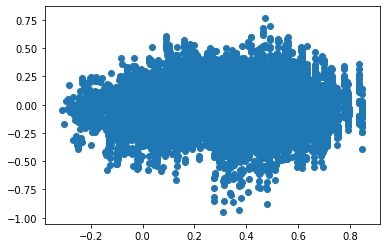

In [41]:
xb = sm.add_constant(X).values @ model.params.values

plt.scatter(xb, model.resid_deviance)
plt.show()